In [63]:
# Importing required libraries
import json
import os
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from IPython.display import Markdown


In [64]:
def load_results(json_file):
    """
    Loads the JSON file and returns a dictionary keyed by file_path.
    Each value is another dictionary with the relevant MIS data.
    """
    try:
        with open(json_file, "r") as f:
            data = json.load(f)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from file '{json_file}': {e}")
        return {}
    except FileNotFoundError:
        print(f"File '{json_file}' not found.")
        return {}
    
    results_dict = {}
    for entry in data:
        file_path = entry.get("file_path")
        if file_path:
            results_dict[file_path] = entry
    return results_dict

def find_mismatches(brute_force_results, greedy_results):
    """
    Compares brute-force MIS results with greedy MIS results.
    Returns a list of file paths where MIS sizes mismatch.
    """
    mismatches = []
    for file_path, bf_entry in brute_force_results.items():
        if file_path not in greedy_results:
            print(f"Greedy MIS results missing for graph '{file_path}'. Skipping comparison.")
            continue  # Can't compare if missing in greedy results
        
        gf_entry = greedy_results[file_path]
        
        bf_mis_size = bf_entry.get("mis_size")
        gf_mis_size = gf_entry.get("greedy_mis_size")
        
        if bf_mis_size != gf_mis_size:
            mismatches.append(file_path)
    
    return mismatches

def select_graph(mismatched_graphs):
    """
    Selects the graph with the least number of nodes.
    If there is a tie, selects the one with the least number of edges.
    """
    selected = None
    min_nodes = float('inf')
    min_edges = float('inf')
    
    for file_path in mismatched_graphs:
        if not os.path.isfile(file_path):
            print(f"Graph file '{file_path}' does not exist. Skipping.")
            continue
        
        try:
            # Assuming the graph files are in edgelist format with integer node labels
            G = nx.read_edgelist(file_path, nodetype=int)
            num_nodes = G.number_of_nodes()
            num_edges = G.number_of_edges()
        except Exception as e:
            print(f"Error reading graph file '{file_path}': {e}. Skipping.")
            continue
        
        if (num_nodes < min_nodes) or (num_nodes == min_nodes and num_edges < min_edges):
            min_nodes = num_nodes
            min_edges = num_edges
            selected = file_path
                
    return selected

def plot_graph(graph, mis_nodes=None, greedy_mis_nodes=None, title="Graph"):
    """
    Plots the graph with optional MIS and greedy MIS nodes highlighted.
    """
    pos = nx.spring_layout(graph)  # Positions for all nodes
    
    plt.figure(figsize=(8,6))
    
    # Draw all nodes in light blue
    nx.draw_networkx_nodes(graph, pos, node_size=300, node_color='lightblue', label='Nodes')
    
    # Highlight MIS nodes in green
    if mis_nodes:
        nx.draw_networkx_nodes(graph, pos, nodelist=mis_nodes, node_size=300, node_color='green', label='MIS')
    
    # Highlight Greedy MIS nodes in yellow
    if greedy_mis_nodes:
        nx.draw_networkx_nodes(graph, pos, nodelist=greedy_mis_nodes, node_size=300, node_color='yellow', label='Greedy MIS')
    
    # Draw edges
    nx.draw_networkx_edges(graph, pos)
    
    # Draw labels
    nx.draw_networkx_labels(graph, pos, font_size=10, font_color='black')
    
    plt.title(title)
    plt.legend(scatterpoints = 1)
    plt.axis('off')
    plt.show()


In [65]:
# Specify the number of nodes
num_nodes = 7

# Specify the paths to the JSON result files
brute_force_file = f"mis_results_{num_nodes}.json"  # e.g., 'mis_results_7.json'
greedy_file = f"greedy_mis_results_{num_nodes}.json"  # e.g., 'greedy_mis_results_7.json'

# Validate the files exist
if not os.path.isfile(brute_force_file):
    raise FileNotFoundError(f"Brute-force MIS file '{brute_force_file}' does not exist.")
if not os.path.isfile(greedy_file):
    raise FileNotFoundError(f"Greedy MIS file '{greedy_file}' does not exist.")



In [66]:
# Load results
brute_force_results = load_results(brute_force_file)
greedy_results = load_results(greedy_file)

# Find mismatches
mismatches = find_mismatches(brute_force_results, greedy_results)

total_graphs_compared = len(brute_force_results)
mismatch_count = len(mismatches)

print(f"Total graphs compared: {total_graphs_compared}")
print(f"Number of mismatches: {mismatch_count}")


Total graphs compared: 1044
Number of mismatches: 10


In [67]:
if mismatch_count == 0:
    print("No mismatches found between brute-force MIS and greedy MIS results.")
else:
    selected_graph_path = select_graph(mismatches)
    if selected_graph_path:
        print(f"Selected Graph for Visualization: {selected_graph_path}")
    else:
        print("No suitable graph found for visualization.")


Selected Graph for Visualization: noniso_7_networkx/graph_666.edgelist


MIS Nodes (Brute-Force): [2, 3, 4]
Greedy MIS Nodes: [1, 4]


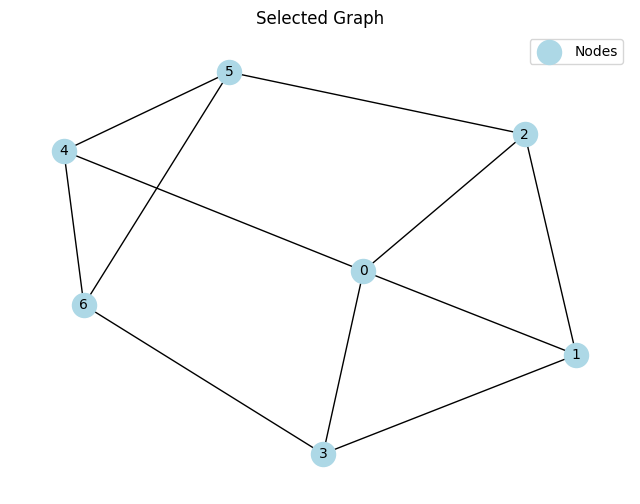

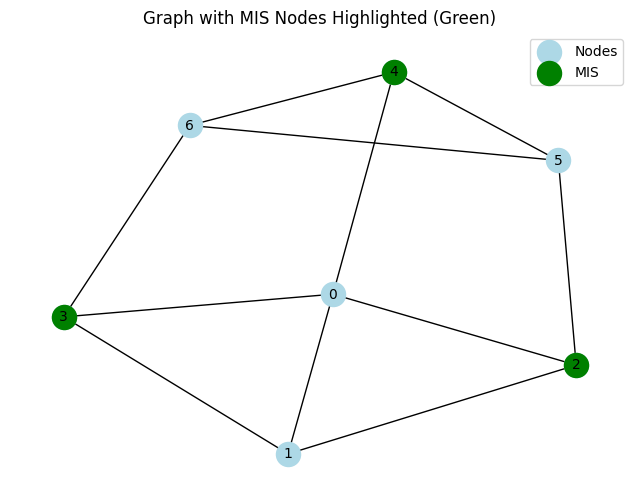

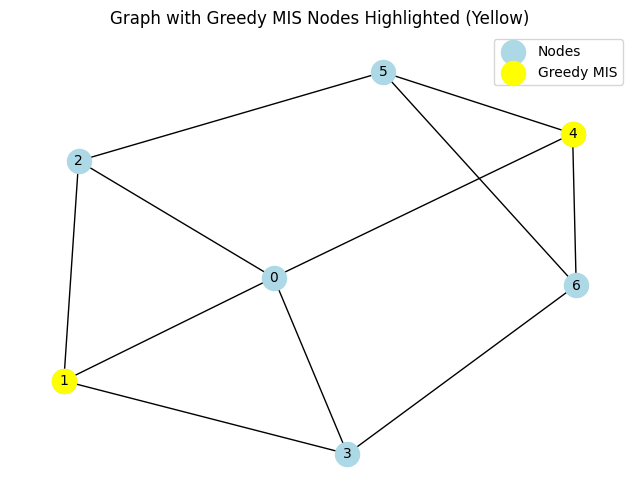

In [68]:
if mismatch_count > 0 and selected_graph_path:
    # Load the selected graph
    try:
        G = nx.read_edgelist(selected_graph_path, nodetype=int)
    except Exception as e:
        print(f"Error reading selected graph file '{selected_graph_path}': {e}. Cannot plot.")
        raise e
    
    # Extract MIS and Greedy MIS nodes
    bf_entry = brute_force_results.get(selected_graph_path, {})
    gf_entry = greedy_results.get(selected_graph_path, {})
    
    mis_nodes = bf_entry.get("maximum_independent_set", [])
    greedy_mis_nodes = gf_entry.get("greedy_mis_set", [])
    
    # Ensure MIS node lists are integers
    mis_nodes = [int(node) for node in mis_nodes]
    greedy_mis_nodes = [int(node) for node in greedy_mis_nodes]
    
    print(f"MIS Nodes (Brute-Force): {mis_nodes}")
    print(f"Greedy MIS Nodes: {greedy_mis_nodes}")
    
    # Plot the graph without highlights
    plot_graph(G, title="Selected Graph")
    
    # Plot with MIS nodes highlighted in green
    plot_graph(G, mis_nodes=mis_nodes, title="Graph with MIS Nodes Highlighted (Green)")
    
    # Plot with Greedy MIS nodes highlighted in yellow
    plot_graph(G, greedy_mis_nodes=greedy_mis_nodes, title="Graph with Greedy MIS Nodes Highlighted (Yellow)")


MIS Nodes (Brute-Force): [2, 4, 5]
Greedy MIS Nodes: [6, 0]


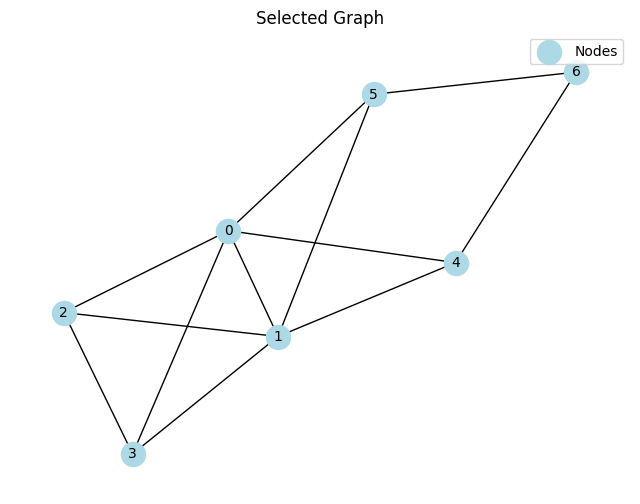

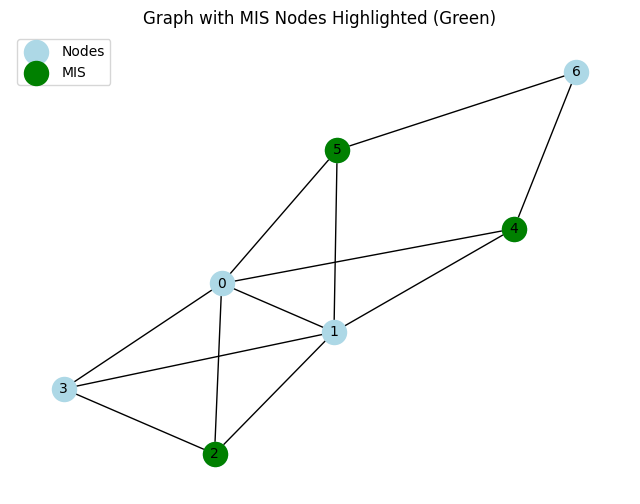

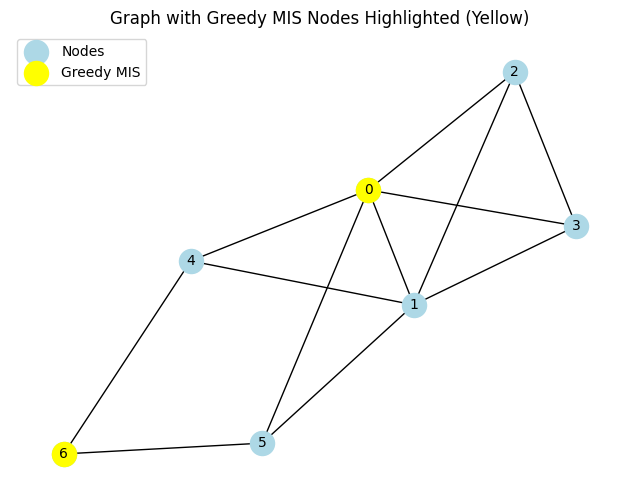

In [69]:
selected_graph_path = 'noniso_7_networkx/graph_713.edgelist'
# Load the selected graph
try:
    G = nx.read_edgelist(selected_graph_path, nodetype=int)
except Exception as e:
    print(f"Error reading selected graph file '{selected_graph_path}': {e}. Cannot plot.")
    raise e

# Extract MIS and Greedy MIS nodes
bf_entry = brute_force_results.get(selected_graph_path, {})
gf_entry = greedy_results.get(selected_graph_path, {})

mis_nodes = bf_entry.get("maximum_independent_set", [])
greedy_mis_nodes = gf_entry.get("greedy_mis_set", [])

# Ensure MIS node lists are integers
mis_nodes = [int(node) for node in mis_nodes]
greedy_mis_nodes = [int(node) for node in greedy_mis_nodes]

print(f"MIS Nodes (Brute-Force): {mis_nodes}")
print(f"Greedy MIS Nodes: {greedy_mis_nodes}")

# Plot the graph without highlights
plot_graph(G, title="Selected Graph")

# Plot with MIS nodes highlighted in green
plot_graph(G, mis_nodes=mis_nodes, title="Graph with MIS Nodes Highlighted (Green)")

# Plot with Greedy MIS nodes highlighted in yellow
plot_graph(G, greedy_mis_nodes=greedy_mis_nodes, title="Graph with Greedy MIS Nodes Highlighted (Yellow)")


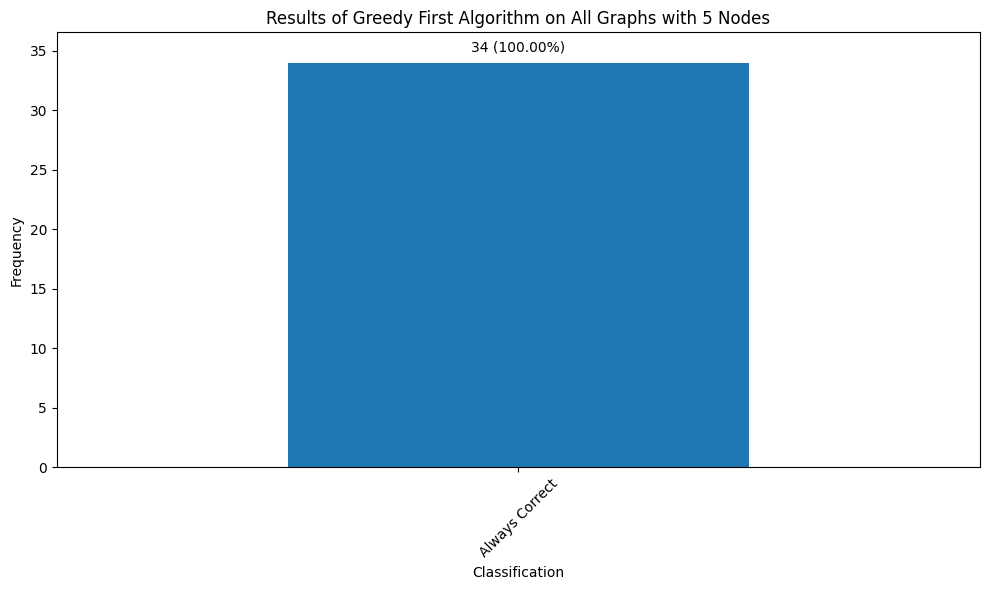

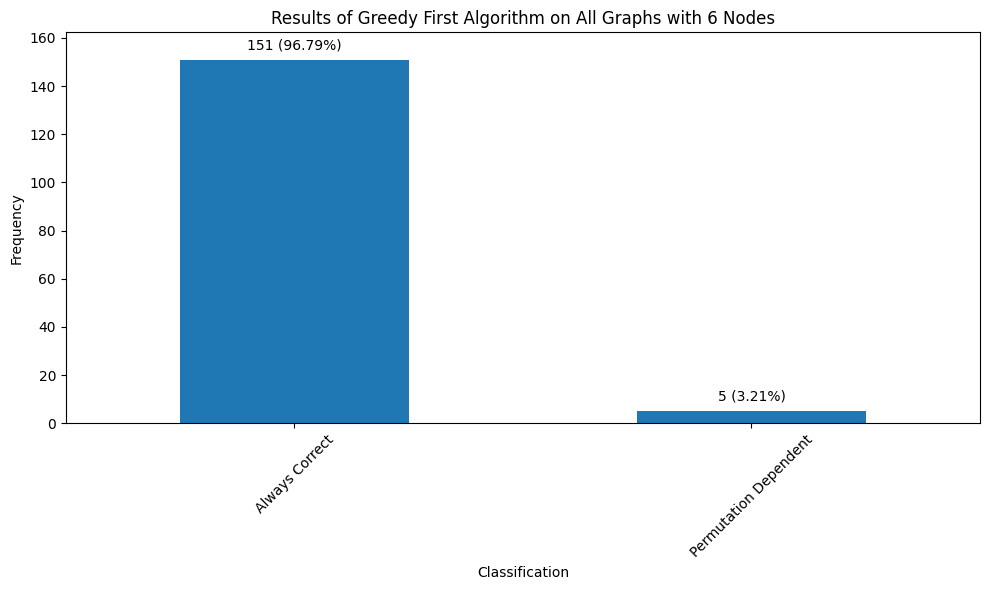

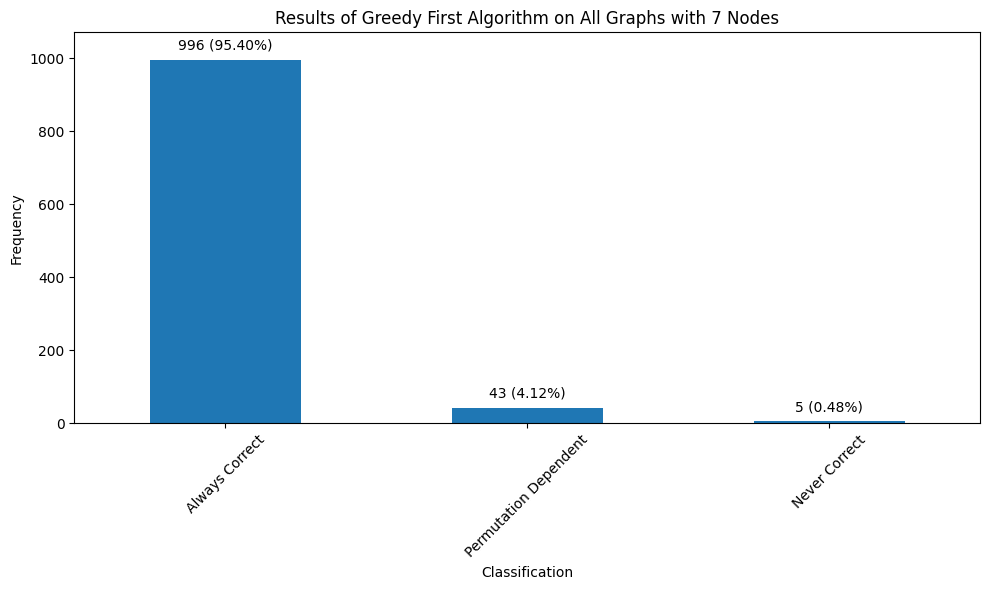

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|c|c|c|}
\hline
Number of Nodes & Non-Isometric Combinations & \% Always Correct & \% Permutation Dependent & \% Never Correct \\ \hline
5 & 34 & 100.00\% & 0.00\% & 0.00\% \\ \hline
6 & 156 & 96.79\% & 3.21\% & 0.00\% \\ \hline
7 & 1044 & 95.40\% & 4.12\% & 0.48\% \\ \hline
\end{tabular}
\caption{Distribution of Solvability of Non-Isometric Undirected Graphs by Their Number of Nodes Using Greedy-First Search.}
\label{tab:nonIsoDistribution}
\end{table}


In [80]:
import pandas as pd
import matplotlib.pyplot as plt

def computeSplitGraph(filePath, title = 'Results of Greedy First Algorithm on All Graphs'):
    # Load the data
    df = pd.read_csv(filePath)

    # Replace classification values with meaningful labels
    df['Classification'] = df['Classification'].replace(1, 'Always Correct')
    df['Classification'] = df['Classification'].replace(2, 'Permutation Dependent')
    df['Classification'] = df['Classification'].replace(3, 'Never Correct')

    # Get value counts for plotting
    value_counts = df['Classification'].value_counts()
    
    # Plot the bar chart
    ax = value_counts.plot(kind='bar', figsize=(10, 6))
    plt.title(title)
    plt.xlabel('Classification')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)

    # Add labels on top of the bars, ensuring they stay within the graph
    for i, (label, count) in enumerate(value_counts.items()):
        # Adjust the vertical position of the text based on the bar height
        y_pos = count + max(value_counts) * 0.02  # Add a small buffer above the bar
        ax.text(i, y_pos, f'{count} ({count / len(df) * 100:.2f}%)', 
                ha='center', va='bottom', fontsize=10)

    # Adjust y-axis limits to ensure all labels are visible
    plt.ylim(0, max(value_counts) * 1.075)

    plt.tight_layout()
    plt.show()
    return value_counts

def generate_latex_table(results, node_counts):
    table = [
        r"\begin{table}[h!]",
        r"\centering",
        r"\begin{tabular}{|c|c|c|c|c|}",
        r"\hline",
        r"Number of Nodes & Non-Isometric Combinations & \% Always Correct & \% Permutation Dependent & \% Never Correct \\ \hline"
    ]
    
    # Process each result and compute the table rows
    for node_count, value_counts in zip(node_counts, results):
        total = sum(value_counts)  # Total number of classifications
        always_correct = value_counts.get('Always Correct', 0)
        permutation_dependent = value_counts.get('Permutation Dependent', 0)
        never_correct = value_counts.get('Never Correct', 0)
        
        # Compute percentages
        always_percent = (always_correct / total) * 100 if total else 0
        permutation_percent = (permutation_dependent / total) * 100 if total else 0
        never_percent = (never_correct / total) * 100 if total else 0
        
        # Append the row to the table
        table.append(
            f"{node_count} & {total} & {always_percent:.2f}\\% & {permutation_percent:.2f}\\% & {never_percent:.2f}\\% \\\\ \\hline"
        )
    
    # Close the table
    table.extend([
        r"\end{tabular}",
        r"\caption{Distribution of Solvability of Non-Isometric Undirected Graphs by Their Number of Nodes Using Greedy-First Search.}",
        r"\label{tab:nonIsoDistribution}",
        r"\end{table}"
    ])
    
    # Join the table lines into a single string
    return "\n".join(table)


node5 = computeSplitGraph('evaluation_results_5.csv', 'Results of Greedy First Algorithm on All Graphs with 5 Nodes')
node6 = computeSplitGraph('evaluation_results_6.csv', 'Results of Greedy First Algorithm on All Graphs with 6 Nodes')
node7 = computeSplitGraph('evaluation_results_7.csv', 'Results of Greedy First Algorithm on All Graphs with 7 Nodes')


node_counts = [5, 6, 7]
results = [node5, node6, node7]
latex_table = generate_latex_table(results, node_counts)
print(latex_table)



